# Chapter 17. 모델 작성에서 범하는 실수들 (Model Misspecification)

모델 명세는 data 에 fitting 하는 일반 함수의 선택을 말한다. 다음을 선택해야 한다.

* 종속변수 
* 독립변수(들)
* 함수 형태

예를 들어, 종속변수는 우리는 종속변수가 두개의 독립변수의 선형 함수임을 가정할 수 있다. 만약 model 이 정확히 기술되지 않으면 regression 가정이 깨어지고 모델은 정확하지 않을 것이다. 아래는 여러가지 공통적인 모델 명세 오류의 정의 및 설명이다.

# 1. 중요 변수를 빠트림 (Exclusion of important variables)

우리가 포함시킨 변수와 correlation 없는 변수를 생략하면, 종속변수를 설명 못하게 될 뿐이지만, 예를들어 포함된 변수 ($X_1$) 와 correlated 된 변수  (이를테면, $X_2$)를 생략하면 model 에 추가적인 영향을 끼친다. regression 에서의 $X_1$ 의 계수와 상수항은 생략된 $X_2$ 를 보상하기위해 편향될 것이다. 이 것은 종속변수에 대한 $X_1$ 효과의 과대평가로 이어진다. 또한 계수 예측치와 standard error 가 일관성이 없어진다.

특히, 실제로는 제 3의 변수(SPY)에 모두 연관된 두 변수(개별 종목)간의 높은 correlation 때문에 두 변수가 일상적인 관계를 가지고 있다고 믿는 경우가 많다.

In [6]:
# Import the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
from googlefinance.client import get_price_data, get_prices_data
import pandas as pd

In [7]:
# Pull the pricing data for our two stocks and S&P 500


start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2015-01-01')

param_STOCK = {'q': "LRCX", 'i': "86400", 'x': "NASD", 'p': "20Y" }
df = pd.DataFrame(get_price_data(param_STOCK))
df.index = pd.to_datetime(df.index.date)
a1 = df['Close'].loc[start : end]

param_STOCK = {'q': "AAPL", 'i': "86400", 'x': "NASD", 'p': "20Y" }
df = pd.DataFrame(get_price_data(param_STOCK))
df.index = pd.to_datetime(df.index.date)
a2 = df['Close'].loc[start : end]

df = get_prices_data( [{'q': ".INX", 'x': "INDEXSP",}], "20Y")
df.index = pd.to_datetime(df.index)
bench = df['.INX_Close'].loc[start:end]

# Perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()
print("R-squared values of linear regression")
print("LRCX and AAPL: ", slr12.rsquared)
print("LRCX and SPY: ", slrb1.rsquared)
print("AAPL and SPY: ", slrb2.rsquared)

R-squared values of linear regression
LRCX and AAPL:  0.907935839126909
LRCX and SPY:  0.8756486051430159
AAPL and SPY:  0.7907549889756499


위 경우 처음에는 LRCX 와 AAPL 이 strong relationship 을 가졌다고 생각할 수 있으나 실제로 두 종목 모두 SPY 와도 높은 관련이 있다는 것을 알게 되면 모델에 SPY (제 3의 변수) 를 포함하고 싶어진다. 그러나 sample 기간을 늘려서 R-squared 값이 어떻게 변하는지 살펴볼 수 있다. 아래의 경우 두 종목의 market 과의 correlation 은 일관성 있으나 두 주식간의 상호관계는 낮아진다. 따라서, 두 종목간의 관계보다는 market 으로부터 가격을 예측하는 것이 나을 것이다.

In [15]:
# Pull pricing data from further back
start = pd.to_datetime('2016-01-01')
end = pd.to_datetime('2017-01-01')

df = pd.DataFrame(get_price_data({'q': "LRCX", 'i': "86400", 'x': "NASD", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
a1 = df['Close'].loc[start : end]

df = pd.DataFrame(get_price_data( {'q': "AAPL", 'i': "86400", 'x': "NASD", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
a2 = df['Close'].loc[start : end]

df = get_prices_data( [{'q': ".INX", 'x': "INDEXSP",}], "10Y")
df.index = pd.to_datetime(df.index)
bench = df['.INX_Close'].loc[start:end]

# Perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()
print("R-squared values of linear regression")
print("LRCX and AAPL: ", slr12.rsquared)
print("LRCX and SPY: ", slrb1.rsquared)
print("AAPL and SPY: ", slrb2.rsquared)

R-squared values of linear regression
LRCX and AAPL:  0.6310438008851669
LRCX and SPY:  0.8399806817568831
AAPL and SPY:  0.4296662000875989


이런 문제를 회피하는 가장 좋은 방법은 regression 분석 시작 전에 종속변수의 좋은 예측자가 될 이유가 있다고 생각하는 독립변수를 고르는 것이다. "시작전" 이 중요하다. regression 분석이 좋아 보인다는 이유만으로 변수를 선택 않는 것이 중요한데 이것이 overfitting 이 될 수 있기 때문이다.

# 2. 불필요한 변수의 포함 (Inclusion of unnecessary variables)

역으로, 필요한 변수를 빠트리는 경우와 달리, 너무 많은 독립변수를 포함시킬 수도 있다. 정말 필요 없는 변수를 포함하면, 더 낮은 보정된 R-squared 와 다른 regression coefficient 의 덜 정밀한 결과를 얻게 되는데, 이 것은 모델 분석의 효과를 떨어트리지만 모델 자체가 변하지는 않는다.

대개 관계없는 변수들을 포함시키면 fit 과 R-squared 를 향상시킬 수 있지만 overfitting 위험이 있다. 예를 들어 아래에서 독립변수로서 PEP 주가와 종속변수로서 PG 주가로 regression 을 수행하고(두 주식이 같은 sector 에 있을 때 의미 있음), 또 다른 regression 을 세개의 임의의 주식으로 수행해 본다.

SLR R-squared: 0.7138101594361173
MLR R-squared: 0.8884744713501181


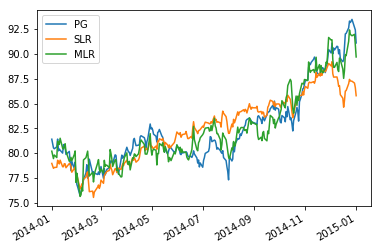

In [21]:
# Load one year's worth of pricing data for five different assets
start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')

df = pd.DataFrame(get_price_data({'q': "PEP", 'i': "86400", 'x': "NASD", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x1 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "MCD", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x2 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "ATHN", 'i': "86400", 'x': "NASD", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x3 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "DOW", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x4 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "PG", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
y = df['Close'].loc[start : end]


# x1 만 가지고 y 를 설명하는 linear model 생성
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# x1, x2, x3, x4 로 y 를 설명하는 multiple linear regression model 생성
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared for the two different models
print('SLR R-squared:', slr.rsquared_adj)
print('MLR R-squared:', mlr.rsquared_adj)

# Plot y along with the two different predictions
y.plot()
slr_prediction.plot()
mlr_prediction.plot()
plt.legend(['PG', 'SLR', 'MLR']);

위 모델을 더 많은 변수들로 조절할 수 있다. 같은 linear model 을 위 기간의 그다음 6 개월에 대해 사용하면 어떻게 되는지 본다.

SLR R-squared: -0.6779563099335961
MLR R-squared: -1.6442837219090713


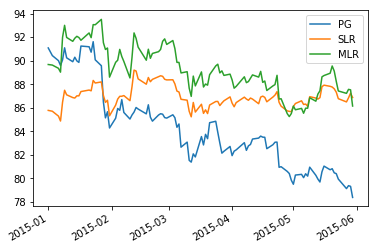

In [23]:
# Load a year and a half of pricing data
start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2015-06-01')

df = pd.DataFrame(get_price_data({'q': "PEP", 'i': "86400", 'x': "NASD", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x1 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "MCD", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x2 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "ATHN", 'i': "86400", 'x': "NASD", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x3 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "DOW", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
x4 = df['Close'].loc[start : end]
df = pd.DataFrame(get_price_data({'q': "PG", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))
df.index = pd.to_datetime(df.index.date)
y = df['Close'].loc[start : end]

# 위에서 구한 모델을 다른 time period 에 적용
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared over the extended time period
adj = float(len(y) - 1)/(len(y) - 5) # Compute adjustment factor
SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print('SLR R-squared:', 1 - adj*SSRs/SST)
SSRm = sum((mlr_prediction2 - y)**2)
print('MLR R-squared:', 1 - adj*SSRm/SST)

# Plot y along with the two different predictions
y.plot()
slr_prediction2.plot()
mlr_prediction2.plot()
plt.legend(['PG', 'SLR', 'MLR']);

위 결과는 single linear regression model 에서도 돈을 잃겠지만 multiple linear regression model 은 완전히 돈을 잃는 것을 보여준다. 이 것은 model 을 simple 하게 가져가야 한다는 것과 예측에 도움이 될 것이란 이유가 없으면 변수에 포함시키지 말라는 것이다.

# 3. 독립변수내의 오차 (Errors in independent variables)

우리가 index 나 날짜를 독립변수로 사용하면 error-free 할 수 있다. 그러나 주식  $X_t$ 의 가치를 독립변수로 사용할 경우 가격만을 측정할 수 있을 뿐인데, 이 것은 작은 불규칙한 fluctuation 들 이다. 따라서 우리는 실제로는 특정 error $u_t$ 에 대한 $Z_t = X_t + u_t$ 를 관찰하는 것이다.
우리의 모델은

$$ Y_t = b_0 + b_1 X_t + \epsilon_t $$ 

인데, 이것은 어떤 변수가 주식의 가치에 밀접히 관련되 있다는 것이다. 그러나 우리가 $Z_t$ 의 가치밖에 모르므로 우리는 다음 모델을 사용한다.

$$ Y_t = b_0 + b_1 Z_t + (-b_1u_t + \epsilon_t) $$

만약 $u_t$ 가 $X_t$ 와 correlated 되어 있지 않다면, $Z_t$ 와 correlated 되어 있을 것이고 오차항 $-b_1u_t + \epsilon_t$ 은 종속변수 $Z_t$ 와 correlate 되어 있을 것 이다. 결과적으로 coefficients 는 편향되고 inconsistent 할 것이다. 특히, $b_1$ 은 아래로 편향될 것이다.

# 4. 부정확한 함수 형태 (Incorrect functional form)

포함시킬 변수들을 선정한 이후, 함수의 형태를 기술해야 한다. regression 이 coefficient 상 linear 한 함수를 요구하지만, 여러가지 형태의 함수를 취급할 수 있다. 예를 들어, 모델 $Y_i = b_0 + b_1 X_i^2 + \epsilon_i$ 은  $X$ 와 $Y$ 간의 이차함수 관계를 나타낸다. 반면, log-linear model $\ln Y_i = b_0 + b_1 X_i + \epsilon_i$ 은 지수함수 형태이다. 일반적으로 예상되는 관계에 따라 함수 형태를 고른다. 예를 들어 log-linear model 은 $Y$ 의 <i>성장속도</i> 를 $X$ 에 대응할 때 유용하다.

잘못된 함수 형태를 고르면, fit 이 잘 되지 않을 수 있다. 실제로 model 의 결론이 이상해진다. 예를 들어, logarithm 을 써야할 때 linear model 을 사용하면, 특정 category 의 회사들이 zero 로 접근하는 대신 - 가 되는 것으로 예측할 수 있다.

또한, data 를 overfit 하는 함수 형태를 선택 않도록 주의해야 한다. 임으로 고차 다항식을 사용하면 더 많은 자유도를 주므로 overfitting 이 된다. 또다른 문제는 data-mining 이다. 여러가지 모델들을 가장 잘 맞을 때까지 시도하면 그 sample 에 overfitting 된 model 이 되고 미래의 예측을 희생하게 된다.

# 5. 다른 종류의 데이터를 섞음 (Pooling different populations)

별도의 모델로 분리하는 것이 더 적절한 두종류의 데이터를 한 모델에서 사용하면 한 쪽, 혹은 다른 쪽에 오류를 보이는 결과를 내게 된다. 예를 들어 여성과 남성의 급여를 섞으면 모델을 fit 하는데 너무 많은 spread 가 있을 수 있다. 아래의 예를 보자.

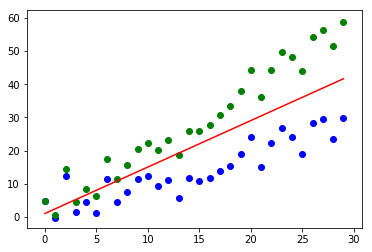

In [24]:
# Generate two artificial samples and pool them
sample1 = np.arange(30) + 4*np.random.randn(30)
sample2 = sample1 + np.arange(30)
pool = np.hstack((sample1, sample2))

# Run a regression on the pooled data, with the independent variable being the original indices
model = regression.linear_model.OLS(pool, sm.add_constant(np.hstack((np.arange(30),np.arange(30))))).fit()

# Plot the two samples along with the regression line
plt.scatter(np.arange(30), sample1, color='b')
plt.scatter(np.arange(30), sample2, color='g')
plt.plot(model.params[0] + model.params[1]*np.arange(30), color='r');

위 경우는 두개의 별도 모델을 가져가야 하는 것이 명확하다. 이런 경우  heteroskedasticity 나 error 의 비정규분포 같이 가정을 위반하는 문제가 발생한다.

역으로, 각각은 correlation 을 보이지 않지만 함께 할 때 correlation model 에 맞는 관측값들의 집합을 하나의 pool 로 할 수 있다. 이 것이 왜 문제인고 하니, 회사의  잉여현금흐름과 영업활동에 따른 현금흐름 관계를 생각해 보면, 아래에서와 같이 시가총액 $100 MM 이상인 운송회사에 대하여 두 항목간에 correlation 이 있음을 알 수 있다. 그러나 잉여현금흐름과 영업활동에 의한 현금흐름간의 correlation 은 회사의 크기에 따른 것처럼 보이고, 그러므로 어떤 정보를 주지 못한다. 이 것은 company size 를 normalize 하지 않은 까닭이다. 그러나 잉여현금흐름과 영업활동에 따른 현금흐름 각각이 회사의 규모와 관계있고 둘 사이의 correlation 은 없을 수도 있다. 이 경우 company size 별로 pool 을 구분하여 분석할 수도 있다.

In [ ]:
# We'll be using pandas DataFrames
import pandas as pd

# Get most recent free cash flow, operating cash flow, and total revenue data
fundamentals = init_fundamentals()
today = pd.datetime.today()
data = get_fundamentals(query(fundamentals.cash_flow_statement.free_cash_flow,
                              fundamentals.cash_flow_statement.operating_cash_flow,
                              fundamentals.income_statement.total_revenue,)
                        .filter(fundamentals.valuation.market_cap > 1e8, # Filter by market cap & industry
                               fundamentals.company_reference.industry_template_code == 'T'), today).T

# Drop missing data
data.dropna(inplace=True)

# Run linear regression and print R-squared value to evaluate the goodness of the fit 
unscaled_model = regression.linear_model.OLS(data['operating_cash_flow'],
                                    sm.add_constant(data['free_cash_flow'])).fit()
prediction = unscaled_model.params[0] + unscaled_model.params[1]*data['free_cash_flow']
print 'R-squared value of model:', unscaled_model.rsquared

# Plot the raw data for visualization
plt.scatter(data['free_cash_flow'], data['operating_cash_flow'])
plt.plot(data['free_cash_flow'], prediction)
plt.legend(['Data', 'Model Prediction'])
plt.xlabel('Free cash flow')
plt.ylabel('Operating cash flow')
plt.title('Transportation companies with market cap > $100 mil');

In [ ]:
# Run linear regression with inputs scaled by total revenue
scaled_model = regression.linear_model.OLS(
    data['operating_cash_flow'].values/data['total_revenue'].values,
    sm.add_constant(data['free_cash_flow'].values/data['total_revenue'].values), missing='drop').fit()
print 'R-squared value of scaled model:', scaled_model.rsquared

prediction = scaled_model.params[0] + scaled_model.params[1]*(data['free_cash_flow'].values/data['total_revenue'].values)

# Plot the scaled data
plt.scatter(data['free_cash_flow'].values/data['total_revenue'].values,
            data['operating_cash_flow'].values/data['total_revenue'].values)
plt.plot(data['free_cash_flow'].values/data['total_revenue'].values, prediction)
plt.legend(['Data', 'Model Prediction'])
plt.xlabel('Free cash flow/Total revenue')
plt.ylabel('Operating cash flow/Total revenue')
plt.title('Transportation companies with market cap > $100 mil');

In general, if we wish to compare data from different populations, we can either analyze them separately or try to adjust for the differences between them. Often we express the variables as ratios, such as scaling by company revenue or by the average wages of each population.

# 6. Nonstationary time series

정상과정 (stationary process) 는 조건부 확률(사건 B가 발생했다는 가정하에 사건 A가 일어날 확률) 이 시간에 따라 변하지 않는 것을 말한다.
특별히, mean 과 variance 가 시간 경과에 일정하다. time series 에 regression model 을 적용할 때는 stationary 하다는 추가 가정이 있어야 한다. 그렇지 않으면 parameter 의 t-statistics 가 valid 하지 못하게 된다.

random walk 는 다음 value 를 가장 잘 예측하는 것이 이전 value 인 process 이다. random 하게 걷게 되면, 각 step 이후의 위치는 step 이전의 위치에 가깝지만 예측할 수 없는 어딘가일 것이다. 공식적으로 이러한 1 차원 walk 는 다음 식으로 나타낸다.

$$ x_t = x_{t-1} + \epsilon_t $$

여기서, error $\epsilon_t$ 은 homoskedastic 하고 평균 0 이며 자기상관이 아니다. 예를 들면, 환율들이 종종 random walks 라고 가정되는데, random walks 는 시간에 따라 variance 가 증가하고, 그러므로 stationary 하지 않다. 가짜 결과를 자주 보이고 두개의 random walk 는 매우 자주 highly correlate 된 것처럼 보이게 된다. 아래 code 를 여러번 수행해 본다.

### All the walks

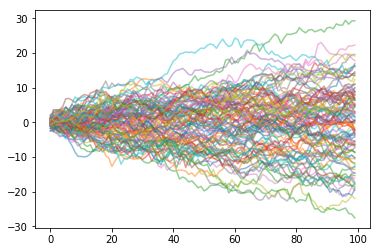

In [48]:
# Generate normally distributed errors
randos = [np.random.randn(100) for i in range(100)]
y = np.random.randn(100)
# Generate random walks
randows = [[sum(rando[:i+1]) for i in range(100)] for rando in randos]
yw = [sum(y[:i+1]) for i in range(100)]

for i in range(100):
    plt.plot(randows[i], alpha=0.5)

### 전혀 correlation 이 없는 위 case 들 중 random 하게 선택하여 correlation test

Linearly related walks out of 100: 6


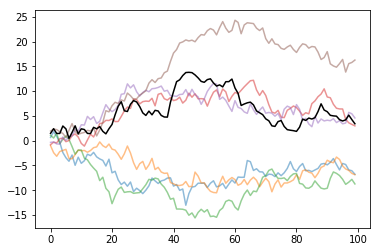

In [49]:
# Compute R-squared of linear regression for each element of randows with yw
rs = [regression.linear_model.OLS(yw, x).fit().rsquared for x in randows]
                    
# Plot and count the random walks that have R-squared with yw > .8
rcount = 0
for i in range(100):
    if rs[i] > .8:
        rcount += 1
        plt.plot(randows[i], alpha=0.5)
print('Linearly related walks out of 100:', rcount)

# Plot yw
plt.plot(yw, color='k');

The reason for the two branches above is that a linear fit works well for both positively and negatively correlated variables.

The result is even more extreme if we look at the random walks with significant correlation, according to the p-values of their correlation coefficients:

Significantly correlated walks out of 100: 70


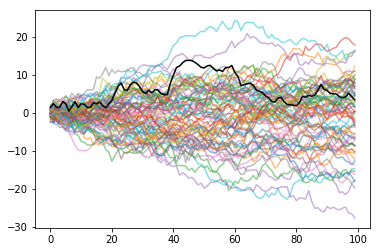

In [50]:
from scipy.stats import pearsonr

# Compute correlation coefficients (Pearson r) and record their p-values
ps = [pearsonr(yw, x)[1] for x in randows]
                    
# Plot and count the random walks that have p-value of correlation with yw < 0.05
pcount = 0
for i in range(100):
    if ps[i] < .05:
        pcount += 1
        plt.plot(randows[i], alpha=0.5)
print('Significantly correlated walks out of 100:', pcount)

# Plot yw
plt.plot(yw, color='k');

위에서 보듯이 거짓 결과의 높은 확률 때문에, random walks 에 대한 regression 에서 얻어진 statistics 는 invalid 하다.

stationary 한 data 는  $x_t = x_{t-1} + \epsilon_t$ 식을 따르지 않는다. (autocorrelated data 는 이전 value 주위에서 움직이므로 stationary 가 아님)

## 경험상 stock price 는 stationary 하지 않으므로 linear regression model 이나 correlation 을 이용한 model 을 사용하는 것은 매우 위험하다. 그러므로 stationary 의 걱정이 있으면 autocorrelation test 를 실시하는 것이 좋음. 예를 들어 S&P 500 은 50 년 기간으로 보면 normal distribution 이 아니므로, high spike 가 있고 fat tail 이 있음.

We can detect random walks and related time series (such as a random walk with drift) by checking for the presence of a <i>unit root</i> in the time series; that is, whether or not it appears to follow the equation $x_t = x_{t-1} + \epsilon_t$. One method is using the Dickey-Fuller test:

In [51]:
from statsmodels.tsa.stattools import adfuller

# Compute the p-value of the Dickey-Fuller statistic to test the null hypothesis that yw has a unit root
print(adfuller(yw)[1])

0.4264547925110247


Therefore we cannot reject the hypothesis that `yw` has a unit root (as we know it does, by construction). If we know that a time series has a unit root and we would like to analyze it anyway, we can model instead the first differenced series $y_t = x_t - x_{t-1}$ if that is stationary, and use it to predict future values of $x$. We can also use regression if both the dependent and independent variables are time series with unit roots and the two are cointegrated.